# Imports

In [1]:
import importlib
import sys
import torch

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')

# Data

### Load Data Files

In [2]:
# Path to your pickle file (saved with torch.save)
file_path_train = '../../../../encoded_data/log_stand/PCR_all_lognormal_5_train.pkl'
# Load the dataset using torch.load
PCR_train_dataset = torch.load(file_path_train, weights_only=False)
# Check the type of the loaded dataset
print(type(PCR_train_dataset))

# Path to your pickle file (saved with torch.save)
file_path_val = '../../../../encoded_data/log_stand/PCR_all_lognormal_5_val.pkl'
# Load the dataset using torch.load
PCR_val_dataset = torch.load(file_path_val, weights_only=False)
# Check the type of the loaded dataset
print(type(PCR_val_dataset))

<class 'event_log_loader.new_event_log_loader.EventLogDataset'>
<class 'event_log_loader.new_event_log_loader.EventLogDataset'>


### Train Data Insights

In [3]:
# PCR Dataset Categories, Features:

PCR_all_categories = PCR_train_dataset.all_categories

PCR_all_categories_cat = PCR_all_categories[0]
print(PCR_all_categories_cat)

PCR_all_categories_num = PCR_all_categories[1]
print(PCR_all_categories_num)

for i, cat in enumerate(PCR_all_categories_cat):
     print(f"PCR (5) Categorical feature: {cat[0]}, Index position in categorical data list: {i}")
     print(f"PCR (5) Total Amount of Category labels: {cat[1]}")
print('\n')    
for i, num in enumerate(PCR_all_categories_num):
     print(f"PCR (5) Numerical feature: {num[0]}, Index position in categorical data list: {i}")
     print(f"PCR (5) Amount Category Lables: {num[1]}")

[('concept:name', 10, {'Callback timeout': 1, 'EOS': 2, 'Export result': 3, 'Export to EMS': 4, 'Match patient data': 5, 'Receive sample state': 6, 'Send notification': 7, 'Wait for plate validation': 8, 'timeout': 9}), ('cpee:lifecycle:transition', 6, {'EOS': 1, 'activity/calling': 2, 'activity/done': 3, 'activity/receiving': 4, 'dataelements/change': 5})]
[('day_in_week', 1, {}), ('seconds_in_day', 1, {}), ('case_elapsed_time', 1, {}), ('event_elapsed_time', 1, {})]
PCR (5) Categorical feature: concept:name, Index position in categorical data list: 0
PCR (5) Total Amount of Category labels: 10
PCR (5) Categorical feature: cpee:lifecycle:transition, Index position in categorical data list: 1
PCR (5) Total Amount of Category labels: 6


PCR (5) Numerical feature: day_in_week, Index position in categorical data list: 0
PCR (5) Amount Category Lables: 1
PCR (5) Numerical feature: seconds_in_day, Index position in categorical data list: 1
PCR (5) Amount Category Lables: 1
PCR (5) Numerica

### Input Features for Encoder and Decoder

In [4]:
# Create lists with name of Encoder features (input) and decoder features (input & output)

# Encoder features:
enc_feat_cat = []
enc_feat_num = []
for cat in PCR_all_categories_cat:
    enc_feat_cat.append(cat[0])
for num in PCR_all_categories_num:
    enc_feat_num.append(num[0])
enc_feat = [enc_feat_cat, enc_feat_num]
print("Input features encoder: ", enc_feat)

# Decoder features:
dec_feat_cat = ['concept:name']
dec_feat_num = ['case_elapsed_time', 'event_elapsed_time']
dec_feat = [dec_feat_cat, dec_feat_num]
print("Features decoder: ", dec_feat)

Input features encoder:  [['concept:name', 'cpee:lifecycle:transition'], ['day_in_week', 'seconds_in_day', 'case_elapsed_time', 'event_elapsed_time']]
Features decoder:  [['concept:name'], ['case_elapsed_time', 'event_elapsed_time']]


# Model

In [5]:
import model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model
importlib.reload(model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model)
from model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

# Prediction decoder output sequence length
seq_len_pred = 4

# Size hidden layer
hidden_size = 128

# Number of cells
num_layers = 4

# Fixed Dropout probability 
dropout = 0.1

# Encoder Decoder model initialization
model = DropoutUncertaintyEncoderDecoderLSTM(data_set_categories=PCR_all_categories,
                                             enc_feat=enc_feat,
                                             dec_feat=dec_feat,
                                             seq_len_pred=seq_len_pred,
                                             hidden_size=hidden_size,
                                             num_layers=num_layers,
                                             dropout=dropout)

Data set categories:  ([('concept:name', 10, {'Callback timeout': 1, 'EOS': 2, 'Export result': 3, 'Export to EMS': 4, 'Match patient data': 5, 'Receive sample state': 6, 'Send notification': 7, 'Wait for plate validation': 8, 'timeout': 9}), ('cpee:lifecycle:transition', 6, {'EOS': 1, 'activity/calling': 2, 'activity/done': 3, 'activity/receiving': 4, 'dataelements/change': 5})], [('day_in_week', 1, {}), ('seconds_in_day', 1, {}), ('case_elapsed_time', 1, {}), ('event_elapsed_time', 1, {})])
Encoder input features:  [['concept:name', 'cpee:lifecycle:transition'], ['day_in_week', 'seconds_in_day', 'case_elapsed_time', 'event_elapsed_time']]
Decoder input+output features:  [['concept:name'], ['case_elapsed_time', 'event_elapsed_time']]


Sequence length of decoder output:  4


Cells hidden size:  128
Number of LSTM layer:  4
Dropout rate:  0.1


Encoder number of labels for each input feature (categorical, numerical):  [[10, 6], [1, 1, 1, 1]]
Encoder indices of tensors in dataset used a

# Loss Object Creation

In [6]:
import loss.losses
importlib.reload(loss.losses)
from loss.losses import Loss

loss_obj = Loss()

# Numerical features trained with log-normal loss:
log_normal_loss_num_feature = ['case_elapsed_time', 'event_elapsed_time']

# Training Configuration

In [7]:
import trainer.trainer
importlib.reload(trainer.trainer)
from trainer.trainer import Trainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(comment="Full_PCR_grad_lognormal")

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start learning rate
learning_rate = 1e-4

# Optimizer and Scheduler
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=2, min_lr=1e-9)

# Epochs
num_epochs = 100

# Batch size
batch_size = 128

# lambda for L2 (weight, bias, dropout) regularization: According to formula: 1/2N
# regularization_term = 1.0/(2.0*batch_size)
regularization_term =  1e-4

# shuffle data
shuffle = True

# Teacher forcing: Smaller 0.5 more predicted events are used for next event prediction.
teacher_forcing_ratio = 0.8

optimize_values = {"regularization_term":regularization_term,
                   "optimizer":optimizer,
                   "scheduler": scheduler,
                   "epochs":num_epochs,
                   "mini_batches":batch_size,
                   "shuffle": shuffle,
                   "teacher_forcing_ratio":teacher_forcing_ratio,}

suffix_data_split_value = 4

# GradNorm parameter
use_gradnorm = True
gn_alpha = 1.5
gn_learning_rate = 1e-4
# gn_learning_rate =  0.025

number_tasks = len(dec_feat[0]) + len(dec_feat[1])

gradNorm = {"use_gradnorm":use_gradnorm,
            "number_tasks": number_tasks,
            "gn_alpha":gn_alpha,
            "gn_learning_rate": gn_learning_rate}

trainer = Trainer(device=device,
                  model=model,
                  data_train=PCR_train_dataset,
                  data_val=PCR_val_dataset,
                  loss_obj=loss_obj,
                  log_normal_loss_num_feature = log_normal_loss_num_feature,
                  optimize_values=optimize_values,
                  suffix_data_split_value=suffix_data_split_value,
                  writer=writer,
                  gradnorm_values=gradNorm,
                  save_model_n_th_epoch = 1,
                  saving_path = 'PCR_full_grad_lognorm_v1.pkl')

# Train the model:
train_attenuated_losses, val_losses, val_attenuated_losses = trainer.train_model()

Device:  cuda
Model:  DropoutUncertaintyEncoderDecoderLSTM(
  (embeddings_enc): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(6, 4)
  )
  (encoder): DropoutUncertaintyLSTMEncoder(
    (embeddings): ModuleList(
      (0): Embedding(10, 6)
      (1): Embedding(6, 4)
    )
    (first_layer): DropoutUncertaintyLSTMCell(
      (Wi): Linear(in_features=14, out_features=128, bias=True)
      (Ui): Linear(in_features=128, out_features=128, bias=True)
      (Wf): Linear(in_features=14, out_features=128, bias=True)
      (Uf): Linear(in_features=128, out_features=128, bias=True)
      (Wc): Linear(in_features=14, out_features=128, bias=True)
      (Uc): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=14, out_features=128, bias=True)
      (Uo): Linear(in_features=128, out_features=128, bias=True)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x DropoutUncertaintyLSTMCell(
        (Wi): Linear(in_features=128, out_features=128, bias=True)
    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 1.1773


Validation: Avg Standard Validation Loss: 1.8694
Validation: Avg Attenuated Validation Loss: 0.1249
Validation Loss for Scheduler: 1.8694
saving model


Epoch [2/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.0690


Validation: Avg Standard Validation Loss: 1.6031
Validation: Avg Attenuated Validation Loss: -0.0500
Validation Loss for Scheduler: 1.6031
saving model


Epoch [3/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.5413


Validation: Avg Standard Validation Loss: 1.4422
Validation: Avg Attenuated Validation Loss: -0.1518
Validation Loss for Scheduler: 1.4422
saving model


Epoch [4/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.8768


Validation: Avg Standard Validation Loss: 1.3177
Validation: Avg Attenuated Validation Loss: -0.2559
Validation Loss for Scheduler: 1.3177
saving model


Epoch [5/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.1077


Validation: Avg Standard Validation Loss: 1.1857
Validation: Avg Attenuated Validation Loss: -0.0150
Validation Loss for Scheduler: 1.1857
saving model


Epoch [6/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.2261


Validation: Avg Standard Validation Loss: 1.0857
Validation: Avg Attenuated Validation Loss: -0.3121
Validation Loss for Scheduler: 1.0857
saving model


Epoch [7/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.3806


Validation: Avg Standard Validation Loss: 1.0299
Validation: Avg Attenuated Validation Loss: -0.2527
Validation Loss for Scheduler: 1.0299
saving model


Epoch [8/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.4817


Validation: Avg Standard Validation Loss: 0.9738
Validation: Avg Attenuated Validation Loss: -0.6608
Validation Loss for Scheduler: 0.9738
saving model


Epoch [9/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.5695


Validation: Avg Standard Validation Loss: 0.9735
Validation: Avg Attenuated Validation Loss: -0.5040
Validation Loss for Scheduler: 0.9735
saving model


Epoch [10/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.2719


Validation: Avg Standard Validation Loss: 0.9163
Validation: Avg Attenuated Validation Loss: 0.7262
Validation Loss for Scheduler: 0.9163
saving model


Epoch [11/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.2134


Validation: Avg Standard Validation Loss: 0.8919
Validation: Avg Attenuated Validation Loss: -0.2757
Validation Loss for Scheduler: 0.8919
saving model


Epoch [12/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.2708


Validation: Avg Standard Validation Loss: 0.8591
Validation: Avg Attenuated Validation Loss: 0.7069
Validation Loss for Scheduler: 0.8591
saving model


Epoch [13/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.2516


Validation: Avg Standard Validation Loss: 0.8509
Validation: Avg Attenuated Validation Loss: -0.3320
Validation Loss for Scheduler: 0.8509
saving model


Epoch [14/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.1945


Validation: Avg Standard Validation Loss: 0.8726
Validation: Avg Attenuated Validation Loss: 0.9464
Validation Loss for Scheduler: 0.8726
saving model


Epoch [15/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.1862


Validation: Avg Standard Validation Loss: 0.8164
Validation: Avg Attenuated Validation Loss: -0.0447
Validation Loss for Scheduler: 0.8164
saving model


Epoch [16/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.1153


Validation: Avg Standard Validation Loss: 0.7947
Validation: Avg Attenuated Validation Loss: 0.6337
Validation Loss for Scheduler: 0.7947
saving model


Epoch [17/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.0502


Validation: Avg Standard Validation Loss: 0.7850
Validation: Avg Attenuated Validation Loss: 0.4507
Validation Loss for Scheduler: 0.7850
saving model


Epoch [18/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.0384


Validation: Avg Standard Validation Loss: 0.7840
Validation: Avg Attenuated Validation Loss: 1.8192
Validation Loss for Scheduler: 0.7840
saving model


Epoch [19/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.9318


Validation: Avg Standard Validation Loss: 0.8114
Validation: Avg Attenuated Validation Loss: 2.1713
Validation Loss for Scheduler: 0.8114
saving model


Epoch [20/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.7718


Validation: Avg Standard Validation Loss: 0.7766
Validation: Avg Attenuated Validation Loss: 2.3333
Validation Loss for Scheduler: 0.7766
saving model


Epoch [21/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.6896


Validation: Avg Standard Validation Loss: 0.7624
Validation: Avg Attenuated Validation Loss: 1.1602
Validation Loss for Scheduler: 0.7624
saving model


Epoch [22/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.5275


Validation: Avg Standard Validation Loss: 0.7391
Validation: Avg Attenuated Validation Loss: 2.3987
Validation Loss for Scheduler: 0.7391
saving model


Epoch [23/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.4385


Validation: Avg Standard Validation Loss: 0.7975
Validation: Avg Attenuated Validation Loss: 4.4087
Validation Loss for Scheduler: 0.7975
saving model


Epoch [24/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.2619


Validation: Avg Standard Validation Loss: 0.7507
Validation: Avg Attenuated Validation Loss: 3.0214
Validation Loss for Scheduler: 0.7507
saving model


Epoch [25/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.3493


Validation: Avg Standard Validation Loss: 0.7493
Validation: Avg Attenuated Validation Loss: 3.1616
Validation Loss for Scheduler: 0.7493
saving model


Epoch [26/100], Learning Rate: 1.0000000000000002e-06, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.5212


Validation: Avg Standard Validation Loss: 0.7480
Validation: Avg Attenuated Validation Loss: 3.9053
Validation Loss for Scheduler: 0.7480
saving model


Epoch [27/100], Learning Rate: 1.0000000000000002e-06, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.0776


Validation: Avg Standard Validation Loss: 0.7536
Validation: Avg Attenuated Validation Loss: 4.6111
Validation Loss for Scheduler: 0.7536
saving model


Epoch [28/100], Learning Rate: 1.0000000000000002e-06, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0457


Validation: Avg Standard Validation Loss: 0.7456
Validation: Avg Attenuated Validation Loss: 4.5831
Validation Loss for Scheduler: 0.7456
saving model


Epoch [29/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.0035


Validation: Avg Standard Validation Loss: 0.7381
Validation: Avg Attenuated Validation Loss: 4.6314
Validation Loss for Scheduler: 0.7381
saving model


Epoch [30/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.0299


Validation: Avg Standard Validation Loss: 0.7425
Validation: Avg Attenuated Validation Loss: 4.6410
Validation Loss for Scheduler: 0.7425
saving model


Epoch [31/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.1607


Validation: Avg Standard Validation Loss: 0.7441
Validation: Avg Attenuated Validation Loss: 4.6504
Validation Loss for Scheduler: 0.7441
saving model


Epoch [32/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: -0.0255


Validation: Avg Standard Validation Loss: 0.7430
Validation: Avg Attenuated Validation Loss: 4.5610
Validation Loss for Scheduler: 0.7430
saving model


Epoch [33/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0675


Validation: Avg Standard Validation Loss: 0.7433
Validation: Avg Attenuated Validation Loss: 4.6884
Validation Loss for Scheduler: 0.7433
saving model


Epoch [34/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0683


Validation: Avg Standard Validation Loss: 0.7412
Validation: Avg Attenuated Validation Loss: 4.5213
Validation Loss for Scheduler: 0.7412
saving model


Epoch [35/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0283


Validation: Avg Standard Validation Loss: 0.7378
Validation: Avg Attenuated Validation Loss: 4.5620
Validation Loss for Scheduler: 0.7378
saving model


Epoch [36/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.1504


Validation: Avg Standard Validation Loss: 0.7459
Validation: Avg Attenuated Validation Loss: 4.6361
Validation Loss for Scheduler: 0.7459
saving model


Epoch [37/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0133


Validation: Avg Standard Validation Loss: 0.7393
Validation: Avg Attenuated Validation Loss: 4.6938
Validation Loss for Scheduler: 0.7393
saving model


Epoch [38/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0627


Validation: Avg Standard Validation Loss: 0.7418
Validation: Avg Attenuated Validation Loss: 4.6190
Validation Loss for Scheduler: 0.7418
saving model


Epoch [39/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0669


Validation: Avg Standard Validation Loss: 0.7445
Validation: Avg Attenuated Validation Loss: 4.6112
Validation Loss for Scheduler: 0.7445
saving model


Epoch [40/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 0.0527


Validation: Avg Standard Validation Loss: 0.7418
Validation: Avg Attenuated Validation Loss: 4.7115
Validation Loss for Scheduler: 0.7418
saving model


Epoch [41/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1158


Validation: Avg Standard Validation Loss: 0.7426
Validation: Avg Attenuated Validation Loss: 4.6560
Validation Loss for Scheduler: 0.7426
saving model


Epoch [42/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1051


Validation: Avg Standard Validation Loss: 0.7460
Validation: Avg Attenuated Validation Loss: 4.5605
Validation Loss for Scheduler: 0.7460
saving model


Epoch [43/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.3058


Validation: Avg Standard Validation Loss: 0.7413
Validation: Avg Attenuated Validation Loss: 4.6912
Validation Loss for Scheduler: 0.7413
saving model


Epoch [44/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.0532


Validation: Avg Standard Validation Loss: 0.7490
Validation: Avg Attenuated Validation Loss: 4.6507
Validation Loss for Scheduler: 0.7490
saving model


Epoch [45/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1482


Validation: Avg Standard Validation Loss: 0.7459
Validation: Avg Attenuated Validation Loss: 4.6485
Validation Loss for Scheduler: 0.7459
saving model


Epoch [46/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1468


Validation: Avg Standard Validation Loss: 0.7449
Validation: Avg Attenuated Validation Loss: 4.6431
Validation Loss for Scheduler: 0.7449
saving model


Epoch [47/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1598


Validation: Avg Standard Validation Loss: 0.7447
Validation: Avg Attenuated Validation Loss: 4.6975
Validation Loss for Scheduler: 0.7447
saving model


Epoch [48/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1444


Validation: Avg Standard Validation Loss: 0.7391
Validation: Avg Attenuated Validation Loss: 4.8349
Validation Loss for Scheduler: 0.7391
saving model


Epoch [49/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.3156


Validation: Avg Standard Validation Loss: 0.7369
Validation: Avg Attenuated Validation Loss: 4.6134
Validation Loss for Scheduler: 0.7369
saving model


Epoch [50/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1215


Validation: Avg Standard Validation Loss: 0.7372
Validation: Avg Attenuated Validation Loss: 4.6242
Validation Loss for Scheduler: 0.7372
saving model


Epoch [51/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1831


Validation: Avg Standard Validation Loss: 0.7427
Validation: Avg Attenuated Validation Loss: 4.6261
Validation Loss for Scheduler: 0.7427
saving model


Epoch [52/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1306


Validation: Avg Standard Validation Loss: 0.7362
Validation: Avg Attenuated Validation Loss: 4.6302
Validation Loss for Scheduler: 0.7362
saving model


Epoch [53/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1524


Validation: Avg Standard Validation Loss: 0.7411
Validation: Avg Attenuated Validation Loss: 4.6909
Validation Loss for Scheduler: 0.7411
saving model


Epoch [54/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.2095


Validation: Avg Standard Validation Loss: 0.7410
Validation: Avg Attenuated Validation Loss: 4.6542
Validation Loss for Scheduler: 0.7410
saving model


Epoch [55/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1916


Validation: Avg Standard Validation Loss: 0.7404
Validation: Avg Attenuated Validation Loss: 4.6520
Validation Loss for Scheduler: 0.7404
saving model


Epoch [56/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.0874


Validation: Avg Standard Validation Loss: 0.7466
Validation: Avg Attenuated Validation Loss: 4.7101
Validation Loss for Scheduler: 0.7466
saving model


Epoch [57/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1610


Validation: Avg Standard Validation Loss: 0.7434
Validation: Avg Attenuated Validation Loss: 4.6437
Validation Loss for Scheduler: 0.7434
saving model


Epoch [58/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1758


Validation: Avg Standard Validation Loss: 0.7386
Validation: Avg Attenuated Validation Loss: 4.7669
Validation Loss for Scheduler: 0.7386
saving model


Epoch [59/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.1043


Validation: Avg Standard Validation Loss: 0.7356
Validation: Avg Attenuated Validation Loss: 4.7234
Validation Loss for Scheduler: 0.7356
saving model


Epoch [60/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 0.0766


Validation: Avg Standard Validation Loss: 0.7477
Validation: Avg Attenuated Validation Loss: 4.9783
Validation Loss for Scheduler: 0.7477
saving model


Epoch [61/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2101


Validation: Avg Standard Validation Loss: 0.7401
Validation: Avg Attenuated Validation Loss: 4.8725
Validation Loss for Scheduler: 0.7401
saving model


Epoch [62/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3903


Validation: Avg Standard Validation Loss: 0.7385
Validation: Avg Attenuated Validation Loss: 4.6199
Validation Loss for Scheduler: 0.7385
saving model


Epoch [63/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3211


Validation: Avg Standard Validation Loss: 0.7385
Validation: Avg Attenuated Validation Loss: 4.6755
Validation Loss for Scheduler: 0.7385
saving model


Epoch [64/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2034


Validation: Avg Standard Validation Loss: 0.7433
Validation: Avg Attenuated Validation Loss: 4.5817
Validation Loss for Scheduler: 0.7433
saving model


Epoch [65/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2031


Validation: Avg Standard Validation Loss: 0.7416
Validation: Avg Attenuated Validation Loss: 4.7797
Validation Loss for Scheduler: 0.7416
saving model


Epoch [66/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2272


Validation: Avg Standard Validation Loss: 0.7417
Validation: Avg Attenuated Validation Loss: 4.7988
Validation Loss for Scheduler: 0.7417
saving model


Epoch [67/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2393


Validation: Avg Standard Validation Loss: 0.7393
Validation: Avg Attenuated Validation Loss: 4.7127
Validation Loss for Scheduler: 0.7393
saving model


Epoch [68/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3651


Validation: Avg Standard Validation Loss: 0.7418
Validation: Avg Attenuated Validation Loss: 4.8268
Validation Loss for Scheduler: 0.7418
saving model


Epoch [69/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2205


Validation: Avg Standard Validation Loss: 0.7434
Validation: Avg Attenuated Validation Loss: 4.7542
Validation Loss for Scheduler: 0.7434
saving model


Epoch [70/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3144


Validation: Avg Standard Validation Loss: 0.7421
Validation: Avg Attenuated Validation Loss: 4.6404
Validation Loss for Scheduler: 0.7421
saving model


Epoch [71/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2764


Validation: Avg Standard Validation Loss: 0.7400
Validation: Avg Attenuated Validation Loss: 4.7187
Validation Loss for Scheduler: 0.7400
saving model


Epoch [72/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2708


Validation: Avg Standard Validation Loss: 0.7432
Validation: Avg Attenuated Validation Loss: 4.7908
Validation Loss for Scheduler: 0.7432
saving model


Epoch [73/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3145


Validation: Avg Standard Validation Loss: 0.7446
Validation: Avg Attenuated Validation Loss: 4.7193
Validation Loss for Scheduler: 0.7446
saving model


Epoch [74/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2325


Validation: Avg Standard Validation Loss: 0.7384
Validation: Avg Attenuated Validation Loss: 4.6720
Validation Loss for Scheduler: 0.7384
saving model


Epoch [75/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3804


Validation: Avg Standard Validation Loss: 0.7419
Validation: Avg Attenuated Validation Loss: 4.6915
Validation Loss for Scheduler: 0.7419
saving model


Epoch [76/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3304


Validation: Avg Standard Validation Loss: 0.7362
Validation: Avg Attenuated Validation Loss: 4.7652
Validation Loss for Scheduler: 0.7362
saving model


Epoch [77/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2717


Validation: Avg Standard Validation Loss: 0.7427
Validation: Avg Attenuated Validation Loss: 4.7243
Validation Loss for Scheduler: 0.7427
saving model


Epoch [78/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3311


Validation: Avg Standard Validation Loss: 0.7357
Validation: Avg Attenuated Validation Loss: 4.6809
Validation Loss for Scheduler: 0.7357
saving model


Epoch [79/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.2912


Validation: Avg Standard Validation Loss: 0.7380
Validation: Avg Attenuated Validation Loss: 4.7614
Validation Loss for Scheduler: 0.7380
saving model


Epoch [80/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 0.3567


Validation: Avg Standard Validation Loss: 0.7333
Validation: Avg Attenuated Validation Loss: 4.6484
Validation Loss for Scheduler: 0.7333
saving model


Epoch [81/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.4267


Validation: Avg Standard Validation Loss: 0.7392
Validation: Avg Attenuated Validation Loss: 4.8694
Validation Loss for Scheduler: 0.7392
saving model


Epoch [82/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3397


Validation: Avg Standard Validation Loss: 0.7383
Validation: Avg Attenuated Validation Loss: 4.6787
Validation Loss for Scheduler: 0.7383
saving model


Epoch [83/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.2811


Validation: Avg Standard Validation Loss: 0.7361
Validation: Avg Attenuated Validation Loss: 4.6964
Validation Loss for Scheduler: 0.7361
saving model


Epoch [84/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3611


Validation: Avg Standard Validation Loss: 0.7417
Validation: Avg Attenuated Validation Loss: 4.7888
Validation Loss for Scheduler: 0.7417
saving model


Epoch [85/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.4206


Validation: Avg Standard Validation Loss: 0.7396
Validation: Avg Attenuated Validation Loss: 4.6860
Validation Loss for Scheduler: 0.7396
saving model


Epoch [86/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3184


Validation: Avg Standard Validation Loss: 0.7400
Validation: Avg Attenuated Validation Loss: 4.7677
Validation Loss for Scheduler: 0.7400
saving model


Epoch [87/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.4481


Validation: Avg Standard Validation Loss: 0.7391
Validation: Avg Attenuated Validation Loss: 4.8168
Validation Loss for Scheduler: 0.7391
saving model


Epoch [88/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3259


Validation: Avg Standard Validation Loss: 0.7383
Validation: Avg Attenuated Validation Loss: 4.7919
Validation Loss for Scheduler: 0.7383
saving model


Epoch [89/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.4034


Validation: Avg Standard Validation Loss: 0.7458
Validation: Avg Attenuated Validation Loss: 4.7658
Validation Loss for Scheduler: 0.7458
saving model


Epoch [90/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3824


Validation: Avg Standard Validation Loss: 0.7472
Validation: Avg Attenuated Validation Loss: 4.7231
Validation Loss for Scheduler: 0.7472
saving model


Epoch [91/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3647


Validation: Avg Standard Validation Loss: 0.7414
Validation: Avg Attenuated Validation Loss: 4.6677
Validation Loss for Scheduler: 0.7414
saving model


Epoch [92/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.2298


Validation: Avg Standard Validation Loss: 0.7389
Validation: Avg Attenuated Validation Loss: 4.6613
Validation Loss for Scheduler: 0.7389
saving model


Epoch [93/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3705


Validation: Avg Standard Validation Loss: 0.7378
Validation: Avg Attenuated Validation Loss: 4.7332
Validation Loss for Scheduler: 0.7378
saving model


Epoch [94/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3295


Validation: Avg Standard Validation Loss: 0.7319
Validation: Avg Attenuated Validation Loss: 4.6191
Validation Loss for Scheduler: 0.7319
saving model


Epoch [95/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3716


Validation: Avg Standard Validation Loss: 0.7385
Validation: Avg Attenuated Validation Loss: 4.6327
Validation Loss for Scheduler: 0.7385
saving model


Epoch [96/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3671


Validation: Avg Standard Validation Loss: 0.7412
Validation: Avg Attenuated Validation Loss: 4.8351
Validation Loss for Scheduler: 0.7412
saving model


Epoch [97/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3569


Validation: Avg Standard Validation Loss: 0.7447
Validation: Avg Attenuated Validation Loss: 4.7178
Validation Loss for Scheduler: 0.7447
saving model


Epoch [98/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.3661


Validation: Avg Standard Validation Loss: 0.7336
Validation: Avg Attenuated Validation Loss: 4.6542
Validation Loss for Scheduler: 0.7336
saving model


Epoch [99/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.4148


Validation: Avg Standard Validation Loss: 0.7391
Validation: Avg Attenuated Validation Loss: 4.7242
Validation Loss for Scheduler: 0.7391
saving model


Epoch [100/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 0.4564


Validation: Avg Standard Validation Loss: 0.7471
Validation: Avg Attenuated Validation Loss: 4.8661
Validation Loss for Scheduler: 0.7471
saving model
Training complete.
Model saved to path: PCR_full_grad_lognorm_v1.pkl


# Training Visualization

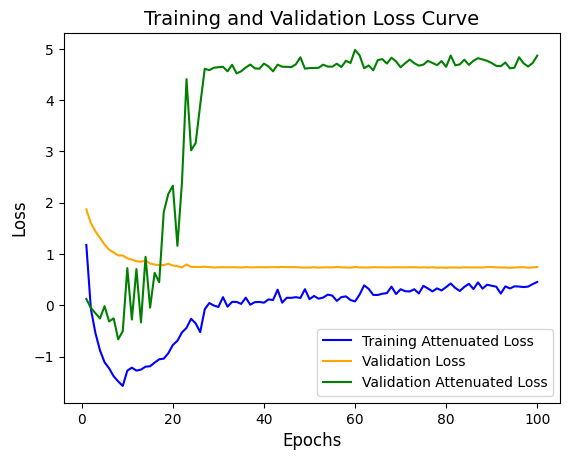

In [8]:
import matplotlib.pyplot as plt

# After training is finished, plot the loss curves
plt.plot(range(1, num_epochs+1), train_attenuated_losses, label='Training Attenuated Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='orange')
plt.plot(range(1, num_epochs+1), val_attenuated_losses, label='Validation Attenuated Loss', color='green')
# Labeling x and y axes
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
# Adding title
plt.title('Training and Validation Loss Curve', fontsize=14)
# Adding legend
plt.legend()
# Show the plot
plt.show()